In [ ]:
# prompt: connect to my drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Feb 10 19:59:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Download pretrained weights
%cd /content/drive/MyDrive/
!git clone https://github.com/IDEA-Research/Grounded-SAM-2.git
%cd /content/drive/MyDrive/Grounded-SAM-2/checkpoints
!bash download_ckpts.sh
%cd /content/drive/MyDrive/Grounded-SAM-2/gdino_checkpoints
!bash download_ckpts.sh

In [ ]:
%cd /content/drive/MyDrive/Grounded-SAM-2/checkpoints
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

In [ ]:
# Download the SUN-RGBD train and test datasets
%cd /content/drive/MyDrive/
!wget http://www.doc.ic.ac.uk/~ahanda/SUNRGBD-train_images.tgz
!mkdir /content/drive/MyDrive/SUNRGBD-train_images
!tar -xzvf SUNRGBD-train_images.tgz -C /content/drive/MyDrive/SUNRGBD-train_images
!wget http://www.doc.ic.ac.uk/~ahanda/SUNRGBD-test_images.tgz
!mkdir /content/drive/MyDrive/SUNRGBD-test_images
!tar -xzvf SUNRGBD-test_images.tgz -C /content/drive/MyDrive/SUNRGBD-test_images

In [ ]:
# Install Grounded SAM2 and Grounding-DINO
%cd /content/drive/MyDrive/Grounded-SAM-2/
!pip3 install torch torchvision opencv-python numpy matplotlib addict yapf
!export CUDA_HOME=/path/to/cuda-12.1/

!pip install -e .
!pip install --no-build-isolation -e grounding_dino
!pip install supervision

/content/drive/MyDrive/Grounded-SAM-2
Obtaining file:///content/drive/MyDrive/Grounded-SAM-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp311-cp311-linux_x86_64.whl size=23936 sha256=db01ddef3d72e9886fb7fe5c936ebada237b63084688b211730f4169b8293bc9
  Stored in directory: /tmp/pip-ephem-wheel-cache-97jsn5af/wheels/e8/c2/2f/988a1a31dbfe76eb59e56a6208b2ec11f0639bd59def3e873d
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0
Obtaining file:///content/drive/MyDrive/Grounded-SAM-2/grounding_dino
  Preparing metadata (setup.py) ... done
  Attempting uninstall: groundingdino
    Found existing installation:

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Grounded-SAM-2/grounding_dino")
sys.path.append("/content/drive/MyDrive/Grounded-SAM-2")

import os
import cv2
import json
from pathlib import Path
from PIL import Image  # Required for saving grayscale PNG
import torch
from torchvision.ops import box_convert
import numpy as np
from grounding_dino.groundingdino.util.inference import load_model, load_image, predict, annotate
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import supervision as sv
%cd /content/drive/MyDrive/Grounded-SAM-2/

# 1️⃣ Hyperparameters
TEXT_PROMPT = "bed. books. ceiling. chait. floor. furniture. curtain. pictures. sofa. table. tv. wall. window."
IMG_DIR = "/content/drive/MyDrive/SUNRGBD-train_images"
OUTPUT_DIR = Path("/content/drive/MyDrive/SUNRGBD-train-segmented-13cls")
SAM2_CHECKPOINT = "./checkpoints/sam2_hiera_large.pt"
SAM2_MODEL_CONFIG = "sam2_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "./grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "./gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DUMP_JSON_RESULTS = True

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 2️⃣ Load SAM2 Model
sam2_model = build_sam2(SAM2_MODEL_CONFIG, SAM2_CHECKPOINT, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

# 3️⃣ Load Grounding DINO Model
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)

# 4️⃣ Function to Save Segmentation Masks
def save_segmentation_mask(masks, class_ids, output_path, num_classes=13):
    """
    Save segmentation results as an 8-bit grayscale PNG with pixel values from 0 to 255.

    Args:
        masks (np.ndarray): Array of shape (N, H, W), where N is the number of classes.
        class_ids (list): List of class indices (e.g., [0,1,2,...,12]).
        output_path (str): File path to save the segmentation mask.
        num_classes (int): Total number of semantic classes (default 13).
    """
    h, w = masks.shape[1:]  # Get image dimensions
    segmentation_map = np.zeros((h, w), dtype=np.uint8)  # Initialize background (0)

    # Assign pixel values based on class ID (scaled to 0-255)
    for i, class_id in enumerate(class_ids):
        segmentation_map[masks[i] > 0] = int((class_id + 1) * (255 / num_classes))  # Scale to 8-bit

    # Convert to 8-bit PNG
    segmentation_image = Image.fromarray(segmentation_map, mode="L")  # "L" mode is 8-bit grayscale

    # Save as PNG
    segmentation_image.save(output_path)
    print(f"✅ Saved segmentation mask at {output_path} (8-bit PNG)")


# 4️⃣ Process Each Image in the Dataset
for img_name in os.listdir(IMG_DIR):
    if not img_name.endswith((".jpg", ".png")):
        continue

    img_path = os.path.join(IMG_DIR, img_name)
    image_source, image = load_image(img_path)

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float32): # bfloat16 might give error in one forwarding layer
        sam2_predictor.set_image(image_source)

        # Object detection with Grounding DINO
        boxes, confidences, labels = predict(
            model=grounding_model,
            image=image,
            caption=TEXT_PROMPT,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD,
        )

    if len(boxes) == 0:
        print(f"⚠️ No objects detected in {img_name}")
        continue

    # Convert to proper format for SAM2
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    # 5️⃣ Segment the objects using SAM2
    masks, scores, logits = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    # Convert masks shape (n, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)

    class_ids = np.array(list(range(len(labels))))  # Assign class indices

    # 7️⃣ Save Segmentation Mask as 0-1 PNG
    output_mask_path = os.path.join(OUTPUT_DIR, f"{img_name}_segmentation.png")
    save_segmentation_mask(masks, class_ids, output_mask_path)

    # confidences = confidences.numpy().tolist()
    # class_names = labels
    # class_ids = np.array(list(range(len(class_names))))

    # labels = [
    #     f"{class_name} {confidence:.2f}"
    #     for class_name, confidence in zip(class_names, confidences)
    # ]

    # # 6️⃣ Visualization using supervision
    # img = cv2.imread(img_path)
    # detections = sv.Detections(
    #     xyxy=input_boxes,
    #     mask=masks.astype(bool),
    #     class_id=class_ids
    # )

    # box_annotator = sv.BoxAnnotator()
    # annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

    # label_annotator = sv.LabelAnnotator()
    # annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
    # cv2.imwrite(os.path.join(OUTPUT_DIR, f"{img_name}_groundingdino.jpg"), annotated_frame)

    # mask_annotator = sv.MaskAnnotator()
    # annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    # cv2.imwrite(os.path.join(OUTPUT_DIR, f"{img_name}_sam2.jpg"), annotated_frame)
    # print(f"✅ Processed: {img_name}")

print(f"🎉 All images processed! Results saved in {OUTPUT_DIR}")

/content/drive/MyDrive/Grounded-SAM-2
final text_encoder_type: bert-base-uncased
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004526.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004131.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004184.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004195.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004539.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004574.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004511.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content

For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004535.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004401.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004455.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004482.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004479.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004291.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004208.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004483.jpg_segmentation.png (8-b

For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004282.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004576.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004413.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004471.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004554.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004605.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004086.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004575.jpg_segmentation.png (8-b

For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004648.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004654.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004759.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004734.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004640.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-005017.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-005001.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-004871.jpg_segmentation.png (8-b

For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003322.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003195.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003386.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003170.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003278.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003496.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003358.jpg_segmentation.png (8-bit PNG)


For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003318.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003351.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003098.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003510.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003135.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003406.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003160.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-003102.jpg_segmentation.png (8-b

For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001544.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001391.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001794.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001801.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001470.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001719.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001458.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001390.jpg_segmentation.png (8-b

For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001515.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001495.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001279.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001295.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001769.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001724.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001661.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-train-segmented-13cls/img-001304.jpg_segmentation.png (8-b

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Grounded-SAM-2/grounding_dino")
sys.path.append("/content/drive/MyDrive/Grounded-SAM-2")

import os
import cv2
import json
from pathlib import Path
from PIL import Image  # Required for saving grayscale PNG
import torch
from torchvision.ops import box_convert
import numpy as np
from grounding_dino.groundingdino.util.inference import load_model, load_image, predict, annotate
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import supervision as sv
%cd /content/drive/MyDrive/Grounded-SAM-2/

# 1️⃣ Hyperparameters
TEXT_PROMPT = "bed. books. ceiling. chait. floor. furniture. curtain. pictures. sofa. table. tv. wall. window."
IMG_DIR = "/content/drive/MyDrive/SUNRGBD-test_images"
OUTPUT_DIR = Path("/content/drive/MyDrive/SUNRGBD-test-segmented-13cls")
SAM2_CHECKPOINT = "./checkpoints/sam2_hiera_large.pt"
SAM2_MODEL_CONFIG = "sam2_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "./grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "./gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 2️⃣ Load SAM2 Model
sam2_model = build_sam2(SAM2_MODEL_CONFIG, SAM2_CHECKPOINT, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

# 3️⃣ Load Grounding DINO Model
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)

# 4️⃣ Function to Save Segmentation Masks
def save_segmentation_mask(masks, class_ids, output_path, num_classes=13):
    """
    Save segmentation results as an 8-bit grayscale PNG with pixel values from 0 to 255.

    Args:
        masks (np.ndarray): Array of shape (N, H, W), where N is the number of classes.
        class_ids (list): List of class indices (e.g., [0,1,2,...,12]).
        output_path (str): File path to save the segmentation mask.
        num_classes (int): Total number of semantic classes (default 13).
    """
    h, w = masks.shape[1:]  # Get image dimensions
    segmentation_map = np.zeros((h, w), dtype=np.uint8)  # Initialize background (0)

    # Assign pixel values based on class ID (scaled to 0-255)
    for i, class_id in enumerate(class_ids):
        segmentation_map[masks[i] > 0] = int((class_id + 1) * (255 / num_classes))  # Scale to 8-bit

    # Convert to 8-bit PNG
    segmentation_image = Image.fromarray(segmentation_map, mode="L")  # "L" mode is 8-bit grayscale

    # Save as PNG
    segmentation_image.save(output_path)
    print(f"✅ Saved segmentation mask at {output_path} (8-bit PNG)")


# 4️⃣ Process Each Image in the Dataset
for img_name in os.listdir(IMG_DIR):
    if not img_name.endswith((".jpg", ".png")):
        continue

    img_path = os.path.join(IMG_DIR, img_name)
    image_source, image = load_image(img_path)

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float32): # bfloat16 might give error in one forwarding layer
        sam2_predictor.set_image(image_source)

        # Object detection with Grounding DINO
        boxes, confidences, labels = predict(
            model=grounding_model,
            image=image,
            caption=TEXT_PROMPT,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD,
        )

    if len(boxes) == 0:
        print(f"⚠️ No objects detected in {img_name}")
        continue

    # Convert to proper format for SAM2
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    # 5️⃣ Segment the objects using SAM2
    masks, scores, logits = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    # Convert masks shape (n, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)

    class_ids = np.array(list(range(len(labels))))  # Assign class indices

    # 7️⃣ Save Segmentation Mask as 0-1 PNG
    output_mask_path = os.path.join(OUTPUT_DIR, f"{img_name}_segmentation.png")
    save_segmentation_mask(masks, class_ids, output_mask_path)

    # confidences = confidences.numpy().tolist()
    # class_names = labels
    # class_ids = np.array(list(range(len(class_names))))

    # labels = [
    #     f"{class_name} {confidence:.2f}"
    #     for class_name, confidence in zip(class_names, confidences)
    # ]

    # # 6️⃣ Visualization using supervision
    # img = cv2.imread(img_path)
    # detections = sv.Detections(
    #     xyxy=input_boxes,
    #     mask=masks.astype(bool),
    #     class_id=class_ids
    # )

    # box_annotator = sv.BoxAnnotator()
    # annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

    # label_annotator = sv.LabelAnnotator()
    # annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
    # cv2.imwrite(os.path.join(OUTPUT_DIR, f"{img_name}_groundingdino.jpg"), annotated_frame)

    # mask_annotator = sv.MaskAnnotator()
    # annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    # cv2.imwrite(os.path.join(OUTPUT_DIR, f"{img_name}_sam2.jpg"), annotated_frame)
    # print(f"✅ Processed: {img_name}")

print(f"🎉 All images processed! Results saved in {OUTPUT_DIR}")

/content/drive/MyDrive/Grounded-SAM-2
final text_encoder_type: bert-base-uncased
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004131.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004109.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004140.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004068.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004184.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004152.jpg_segmentation.png (8-bit PNG)
⚠️ No objects detected in img-004168.jpg
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004171.jpg_segmentation.png (8-bit PNG)
✅ S

For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004057.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004188.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004121.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004100.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004160.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004165.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004091.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004191.jpg_segmentation.png (8-bit PNG)


For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).


✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004289.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004299.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004232.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004244.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004203.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004241.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004271.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-004297.jpg_segmentation.png (8-bit PNG)


For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
For the old behavior, usually:
    np.array(value).astype(dtype)
will gi

✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-001331.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-001302.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-001349.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-001342.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-001324.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-001282.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-001354.jpg_segmentation.png (8-bit PNG)
✅ Saved segmentation mask at /content/drive/MyDrive/SUNRGBD-test-segmented-13cls/img-001358.jpg_segmentation.png (8-bit PNG)


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/SSDI_rebuttal")

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import random
import sunrgbd
import torchvision.transforms as transforms

#%% SEED instantiation
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
#%% Train data
train_data = sunrgbd.SUNRGBD(transform=transforms.Compose([sunrgbd.scaleNorm(height=480, width=640),
                                                           sunrgbd.ToTensor()]),
                             phase_train=True, # set this to True to avoid corruptions
                             data_dir=["/content/drive/MyDrive/SUNRGBD-train-segmented-13cls",],
                             ps=160)
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          num_workers=8,
                          pin_memory=False)
num_train = len(train_data)
print("Train Dataset size: {}".format(num_train))
img = train_data.__getitem__(0)
print("Image shape:", img.shape)  # Expected: [1, 480, 640] for grayscale images

Train Dataset size: 10263
Image shape: torch.Size([1, 480, 640])


In [ ]:
#%% Test data
test_data = sunrgbd.SUNRGBD(transform=transforms.Compose([sunrgbd.scaleNorm(height=480, width=640),
                                                          sunrgbd.ToTensor()]),
                            phase_train=True, # set this to True to avoid corruptions
                            data_dir=["/content/drive/MyDrive/SUNRGBD-test-segmented-13cls"],
                            ps=160)
test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=True,
                         num_workers=8,
                         pin_memory=False)
num_test = len(test_data)
print("Test Dataset size: {}".format(num_test))
img = test_data.__getitem__(0)
print("Image shape:", img.shape)  # Expected: [1, 480, 640] for grayscale images

Test Dataset size: 5015
Image shape: torch.Size([1, 480, 640])


In [ ]:
# Find out the value range over the dataset
min_val = np.inf
max_val = -np.inf
for data in test_loader:
    min_val = min(min_val, data.min().item())
    max_val = max(max_val, data.max().item())
print("Dataset value range:", min_val, max_val)

Dataset value range: 0.0 1.0


In [ ]:
# Rerun after changing LSTM_config
import importlib
import lstm_utils  # Import your module
importlib.reload(lstm_utils)  # Reload it to reflect changes
from lstm_utils import customizable_LSTM as LSTM
from lstm_utils import LSTM_config as LSTM_config
print(LSTM_config.patch_size, LSTM_config.corruption_type, LSTM_config.num_box, LSTM_config.num_distortion)

80 black_box 16 4


In [ ]:
from lstm_utils import customizable_LSTM as LSTM
from lstm_utils import LSTM_config as LSTM_config

#%% LSTM model, checkpoints, optimizer, and lr_scheduler
model_lstm = LSTM(LSTM_config)
model_lstm.cuda()
model_lstm.train()
print("Model M4:\n", "Train from scratch")
print(model_lstm)

optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=LSTM_config.lr_start, weight_decay=LSTM_config.weight_decay)
lr_scheduler_lstm = torch.optim.lr_scheduler.MultiStepLR(optimizer_lstm, gamma=LSTM_config.gamma, milestones=LSTM_config.milestones, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Model M4:
 Train from scratch
customizable_LSTM(
  (fc_mask): Linear(in_features=6400, out_features=128, bias=True)
  (fc_mask_1): Linear(in_features=6400, out_features=1024, bias=True)
  (fc_mask_2): Linear(in_features=1024, out_features=128, bias=True)
  (lstm): LSTM(142, 142, proj_size=14, batch_first=True, dropout=0.2, bidirectional=True)
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
#%% LSTM losses
mse_loss = nn.MSELoss(reduction='mean')
cosine_embedding_loss = nn.CosineEmbeddingLoss(reduction='mean')
# Contrastive Loss function
def contrastive_loss(p_tensor, r_tensor):
    p_norm = p_tensor / p_tensor.norm(dim=1)[:,None]
    r_norm = r_tensor / r_tensor.norm(dim=1)[:,None]
    sim_mat = torch.mm(p_norm, r_norm.transpose(0, 1))
    temp_para = 1
    contr_loss = 0
    for i in range(p_tensor.shape[0]): # for each p, calculate a contrastive loss across all r's
        nom = torch.exp(sim_mat[i,i] / temp_para)
        denom = torch.sum(torch.exp(sim_mat[i,:] / temp_para)) - nom
        p_loss = -torch.log(nom / denom)
        contr_loss += p_loss
    contr_loss /= p_tensor.shape[0]
    return contr_loss

In [ ]:
# Train
# Config: ps=80, epochs=40
import matplotlib.pyplot as plt
from utils import load_ckpt, unfold

epochs = LSTM_config.epochs # 40
patch_size = LSTM_config.patch_size # 80

log_dict = {"train_loss_lstm": [],
            "test_loss_lstm": [],
            "test_threshold": [],
            "test_acc_lstm": []}

# Save path for the trained model
save_path = '/content/drive/MyDrive/LSTM_models_trained_on_sam2_generated_labels/num_classes={}/input_size=640x480/ps={}_bi-lstm_numlayers={}_startlr={}_epoch={}'.format(LSTM_config.semantics_dim, LSTM_config.patch_size, LSTM_config.num_layers, LSTM_config.lr_start, LSTM_config.epochs)
if not os.path.exists(save_path): os.makedirs(save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(0, epochs):
    print("\nEpoch: {}/{}".format(epoch+1, epochs))
    train_loss_lstm = 0.0
    model_lstm.train()
    for batch_idx, image in enumerate(train_loader):
        image = image.to(DEVICE)
        # print(image.shape, image.min().item(), image.max().item()) # [0, 1]

        pred_labels = torch.round((image * (LSTM_config.semantics_dim - 1))).float().to(DEVICE) # [0, 13], 14 classes including bg
        # unique_values, counts = torch.unique(pred_labels, return_counts=True)
        # print(pred_labels.shape, unique_values, counts)
        patch_masks = unfold(X=pred_labels, patch_size=LSTM_config.patch_size) # (bs, num_patch, num_ch=1, ps, ps)
        num_pixels = patch_masks.shape[3] * patch_masks.shape[4] # ps*ps
        patch_masks = patch_masks.flatten(start_dim=2, end_dim=4) # (bs, num_patches, num_pixels)
        mask_semantics = torch.nn.functional.one_hot(patch_masks.long(), num_classes=LSTM_config.semantics_dim).sum(dim=2) # (bs, num_patches, num_semantics)
        mask_semantics_ratio = (mask_semantics.float()) / num_pixels # (bs, num_patches, num_semantics)
        # print(mask_semantics_ratio.shape)

        # feed the sequence of cancatted mask and semantics to LSTM
        # initialize hidden and cell states
        optimizer_lstm.zero_grad()
        h0, c0 = model_lstm._init_hidden(image.shape[0])
        # (2, bs, 14) (D*num_layers, N=bs, H_out), (2, bs, 142) (D*num_layers, N, H_cell), D=2 if bidirectional otherwise 1
        # print(h0.shape, c0.shape)
        loss_lstm = torch.tensor([0.0]).cuda()

        # Compute MSE loss between output_lstm and next semantics embeddings (128-d)
        output_lstm, (hn, cn) = model_lstm([patch_masks, mask_semantics_ratio], (h0, c0))
        # Forward loss
        loss_lstm = mse_loss(output_lstm[:, :-1, :LSTM_config.semantics_dim], mask_semantics_ratio[:, 1:, :]) # both (bs, num_patches, num_semantics)
        # Backward loss
        loss_lstm += mse_loss(output_lstm[:, 1:, LSTM_config.semantics_dim:], mask_semantics_ratio[:, :-1, :]) # both (bs, num_patches, num_semantics)

        # M4 backpropagate after all patch iterations
        loss_lstm.backward()
        optimizer_lstm.step()
        train_loss_lstm += loss_lstm.item()

        # Print every 20 batches
        if (batch_idx+1) % 20 == 0:
            print("Current process: batch: {}/{}, current batch loss: {}".format(batch_idx+1, len(train_loader), loss_lstm.item()))

    # End of current Epoch
    # Print and tally average epoch loss
    print("Train Loss (LSTM) over epoch: {:.5f}\n".format(train_loss_lstm / (batch_idx+1)))
    log_dict['train_loss_lstm'].append(train_loss_lstm / (batch_idx+1))

    # Adjust lr every epoch
    if optimizer_lstm.param_groups[0]['lr'] > LSTM_config.lr_min:
        lr_scheduler_lstm.step()

    # Validate every 5 epochs
    if (epoch + 1) % 5 == 0:
        test_loss_lstm = 0.0
        model_lstm.eval()
        with torch.no_grad():
            for batch_idx, image in enumerate(test_loader):
                image = image.to(device)
                pred_labels = torch.round((image * (LSTM_config.semantics_dim - 1))).float().to(device) # [0, 13], 14 classes including bg
                patch_masks = unfold(X=pred_labels, patch_size=LSTM_config.patch_size) # (bs, num_patch, num_ch=1, ps, ps)
                num_pixels = patch_masks.shape[3] * patch_masks.shape[4] # ps*ps
                patch_masks = patch_masks.flatten(start_dim=2, end_dim=4) # (bs, num_patches, num_pixels)
                mask_semantics = torch.nn.functional.one_hot(patch_masks.long(), num_classes=LSTM_config.semantics_dim).sum(dim=2) # (bs, num_patches, num_semantics)
                mask_semantics_ratio = (mask_semantics.float()) / num_pixels # (bs, num_patches, num_semantics)

                h0, c0 = model_lstm._init_hidden(image.shape[0])
                loss_lstm = torch.tensor([0.0]).cuda()

                # Compute MSE loss between output_lstm and next semantics embeddings (128-d)
                output_lstm, (hn, cn) = model_lstm([patch_masks, mask_semantics_ratio], (h0, c0))
                # Forward loss
                loss_lstm = mse_loss(output_lstm[:, :-1, :LSTM_config.semantics_dim], mask_semantics_ratio[:, 1:, :]) # both (bs, num_patches, num_semantics)
                # Backward loss
                loss_lstm += mse_loss(output_lstm[:, 1:, LSTM_config.semantics_dim:], mask_semantics_ratio[:, :-1, :]) # both (bs, num_patches, num_semantics)
                test_loss_lstm += loss_lstm.item()
        print(f"Validation Loss: {test_loss_lstm / len(test_loader):.4f}")

    # Save model weights and losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print("Saving model: epoch: {}/{}\n".format(epoch+1, LSTM_config.epochs))
        torch.save({'epoch': epoch+1,
                    'state_dict': model_lstm.state_dict(),
                    'optimizer' : optimizer_lstm.state_dict(),
                    'log_dict': log_dict
                    },
                    os.path.join(save_path, 'checkpoint_{}.pth.tar'.format(epoch+1)))

    # Save latest model weights and losses every epoch
    torch.save({'epoch': epoch+1,
                'state_dict': model_lstm.state_dict(),
                'optimizer' : optimizer_lstm.state_dict(),
                'log_dict': log_dict
                },
                os.path.join(save_path, 'checkpoint_latest.pth.tar'))

    # Plot loss curve
    if epoch+1 == LSTM_config.epochs:
        plt.figure()
        plt.plot(np.arange(epoch+1), log_dict['train_loss_lstm'])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss curve over epochs")
        plt.savefig(os.path.join(save_path, "loss_curve.png"))
        plt.close()



Epoch: 1/40
Current process: batch: 20/321, current batch loss: 0.09785651415586472
Current process: batch: 40/321, current batch loss: 0.07620185613632202
Current process: batch: 60/321, current batch loss: 0.06708482652902603
Current process: batch: 80/321, current batch loss: 0.06042080372571945
Current process: batch: 100/321, current batch loss: 0.06341653317213058
Current process: batch: 120/321, current batch loss: 0.06547724455595016
Current process: batch: 140/321, current batch loss: 0.05550083518028259
Current process: batch: 160/321, current batch loss: 0.054892316460609436
Current process: batch: 180/321, current batch loss: 0.060163870453834534
Current process: batch: 200/321, current batch loss: 0.05420573055744171
Current process: batch: 220/321, current batch loss: 0.05804106593132019
Current process: batch: 240/321, current batch loss: 0.053463295102119446
Current process: batch: 260/321, current batch loss: 0.06276584416627884
Current process: batch: 280/321, curren

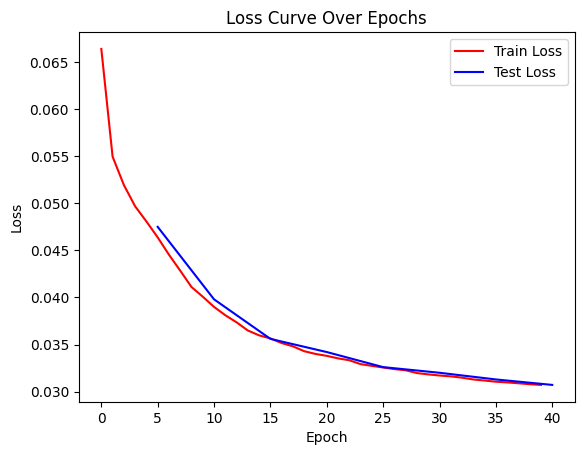

In [ ]:
# Plot loss curve
plt.figure()
plt.plot(np.arange(epoch+1), log_dict['train_loss_lstm'], color='red', label="Train Loss")
plt.plot([5,10,15,20,25,30,35,40], [0.0475,0.0398,0.0356,0.0342,0.0326,0.0320,0.03129,0.03071], color='blue', label="Test Loss")
# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve Over Epochs")
# Add legend in the top-right corner
plt.legend(loc="upper right")
# Save the figure
save_path = "./"  # Change to your actual save directory
plt.savefig(os.path.join(save_path, "loss_curves.png"))
plt.show()

In [ ]:
# Train
# Config: ps=160, epochs=40
import matplotlib.pyplot as plt
from utils import load_ckpt, unfold

epochs = LSTM_config.epochs # 40
patch_size = LSTM_config.patch_size # 160

log_dict = {"train_loss_lstm": [],
            "test_loss_lstm": [],
            "test_threshold": [],
            "test_acc_lstm": []}

# Save path for the trained model
save_path = '/content/drive/MyDrive/LSTM_models_trained_on_sam2_generated_labels/num_classes={}/input_size=640x480/ps={}_bi-lstm_numlayers={}_startlr={}_epoch={}'.format(LSTM_config.semantics_dim, LSTM_config.patch_size, LSTM_config.num_layers, LSTM_config.lr_start, LSTM_config.epochs)
if not os.path.exists(save_path): os.makedirs(save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(0, epochs):
    print("\nEpoch: {}/{}".format(epoch+1, epochs))
    train_loss_lstm = 0.0
    model_lstm.train()
    for batch_idx, image in enumerate(train_loader):
        image = image.to(DEVICE)
        # print(image.shape, image.min().item(), image.max().item()) # [0, 1]

        pred_labels = torch.round((image * (LSTM_config.semantics_dim - 1))).float().to(DEVICE) # [0, 13], 14 classes including bg
        # unique_values, counts = torch.unique(pred_labels, return_counts=True)
        # print(pred_labels.shape, unique_values, counts)
        patch_masks = unfold(X=pred_labels, patch_size=LSTM_config.patch_size) # (bs, num_patch, num_ch=1, ps, ps)
        num_pixels = patch_masks.shape[3] * patch_masks.shape[4] # ps*ps
        patch_masks = patch_masks.flatten(start_dim=2, end_dim=4) # (bs, num_patches, num_pixels)
        mask_semantics = torch.nn.functional.one_hot(patch_masks.long(), num_classes=LSTM_config.semantics_dim).sum(dim=2) # (bs, num_patches, num_semantics)
        mask_semantics_ratio = (mask_semantics.float()) / num_pixels # (bs, num_patches, num_semantics)
        # print(mask_semantics_ratio.shape)

        # feed the sequence of cancatted mask and semantics to LSTM
        # initialize hidden and cell states
        optimizer_lstm.zero_grad()
        h0, c0 = model_lstm._init_hidden(image.shape[0])
        # (2, bs, 14) (D*num_layers, N=bs, H_out), (2, bs, 142) (D*num_layers, N, H_cell), D=2 if bidirectional otherwise 1
        # print(h0.shape, c0.shape)
        loss_lstm = torch.tensor([0.0]).cuda()

        # Compute MSE loss between output_lstm and next semantics embeddings (128-d)
        output_lstm, (hn, cn) = model_lstm([patch_masks, mask_semantics_ratio], (h0, c0))
        # Forward loss
        loss_lstm = mse_loss(output_lstm[:, :-1, :LSTM_config.semantics_dim], mask_semantics_ratio[:, 1:, :]) # both (bs, num_patches, num_semantics)
        # Backward loss
        loss_lstm += mse_loss(output_lstm[:, 1:, LSTM_config.semantics_dim:], mask_semantics_ratio[:, :-1, :]) # both (bs, num_patches, num_semantics)

        # M4 backpropagate after all patch iterations
        loss_lstm.backward()
        optimizer_lstm.step()
        train_loss_lstm += loss_lstm.item()

        # Print every 20 batches
        if (batch_idx+1) % 20 == 0:
            print("Current process: batch: {}/{}, current batch loss: {}".format(batch_idx+1, len(train_loader), loss_lstm.item()))

    # End of current Epoch
    # Print and tally average epoch loss
    print("Train Loss (LSTM) over epoch: {:.5f}\n".format(train_loss_lstm / (batch_idx+1)))
    log_dict['train_loss_lstm'].append(train_loss_lstm / (batch_idx+1))

    # Adjust lr every epoch
    if optimizer_lstm.param_groups[0]['lr'] > LSTM_config.lr_min:
        lr_scheduler_lstm.step()

    # Validate every 5 epochs
    if (epoch + 1) % 5 == 0:
        test_loss_lstm = 0.0
        model_lstm.eval()
        with torch.no_grad():
            for batch_idx, image in enumerate(test_loader):
                image = image.to(device)
                pred_labels = torch.round((image * (LSTM_config.semantics_dim - 1))).float().to(device) # [0, 13], 14 classes including bg
                patch_masks = unfold(X=pred_labels, patch_size=LSTM_config.patch_size) # (bs, num_patch, num_ch=1, ps, ps)
                num_pixels = patch_masks.shape[3] * patch_masks.shape[4] # ps*ps
                patch_masks = patch_masks.flatten(start_dim=2, end_dim=4) # (bs, num_patches, num_pixels)
                mask_semantics = torch.nn.functional.one_hot(patch_masks.long(), num_classes=LSTM_config.semantics_dim).sum(dim=2) # (bs, num_patches, num_semantics)
                mask_semantics_ratio = (mask_semantics.float()) / num_pixels # (bs, num_patches, num_semantics)

                h0, c0 = model_lstm._init_hidden(image.shape[0])
                loss_lstm = torch.tensor([0.0]).cuda()

                # Compute MSE loss between output_lstm and next semantics embeddings (128-d)
                output_lstm, (hn, cn) = model_lstm([patch_masks, mask_semantics_ratio], (h0, c0))
                # Forward loss
                loss_lstm = mse_loss(output_lstm[:, :-1, :LSTM_config.semantics_dim], mask_semantics_ratio[:, 1:, :]) # both (bs, num_patches, num_semantics)
                # Backward loss
                loss_lstm += mse_loss(output_lstm[:, 1:, LSTM_config.semantics_dim:], mask_semantics_ratio[:, :-1, :]) # both (bs, num_patches, num_semantics)
                test_loss_lstm += loss_lstm.item()
        print(f"Validation Loss: {test_loss_lstm / len(test_loader):.4f}")

    # Save model weights and losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print("Saving model: epoch: {}/{}\n".format(epoch+1, LSTM_config.epochs))
        torch.save({'epoch': epoch+1,
                    'state_dict': model_lstm.state_dict(),
                    'optimizer' : optimizer_lstm.state_dict(),
                    'log_dict': log_dict
                    },
                    os.path.join(save_path, 'checkpoint_{}.pth.tar'.format(epoch+1)))

    # Save latest model weights and losses every epoch
    torch.save({'epoch': epoch+1,
                'state_dict': model_lstm.state_dict(),
                'optimizer' : optimizer_lstm.state_dict(),
                'log_dict': log_dict
                },
                os.path.join(save_path, 'checkpoint_latest.pth.tar'))

    # Plot loss curve
    if epoch+1 == LSTM_config.epochs:
        plt.figure()
        plt.plot(np.arange(epoch+1), log_dict['train_loss_lstm'])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss curve over epochs")
        plt.savefig(os.path.join(save_path, "loss_curve.png"))
        plt.close()



Epoch: 1/40
Current process: batch: 20/321, current batch loss: 0.09864337742328644
Current process: batch: 40/321, current batch loss: 0.08133013546466827
Current process: batch: 60/321, current batch loss: 0.06955821812152863
Current process: batch: 80/321, current batch loss: 0.07052019238471985
Current process: batch: 100/321, current batch loss: 0.06745041906833649
Current process: batch: 120/321, current batch loss: 0.06256736814975739
Current process: batch: 140/321, current batch loss: 0.060560889542102814
Current process: batch: 160/321, current batch loss: 0.048785753548145294
Current process: batch: 180/321, current batch loss: 0.060786306858062744
Current process: batch: 200/321, current batch loss: 0.05410376936197281
Current process: batch: 220/321, current batch loss: 0.05260413885116577
Current process: batch: 240/321, current batch loss: 0.05128994584083557
Current process: batch: 260/321, current batch loss: 0.051507994532585144
Current process: batch: 280/321, curre

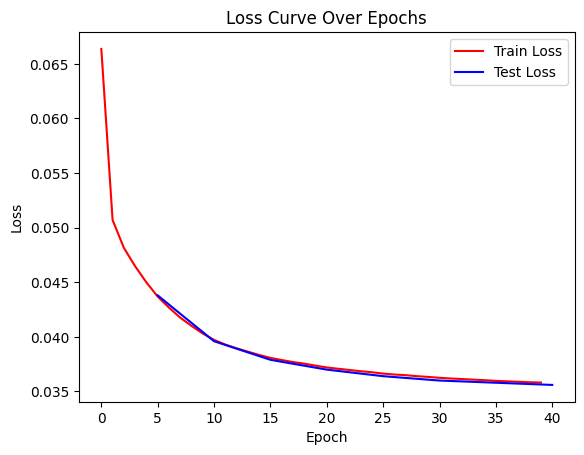

In [ ]:
# Plot loss curve
plt.figure()
plt.plot(np.arange(epoch+1), log_dict['train_loss_lstm'], color='red', label="Train Loss")
plt.plot([5,10,15,20,25,30,35,40], [0.0438,0.0396,0.0379,0.0370,0.0364,0.0360,0.0358,0.0356], color='blue', label="Test Loss")
# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve Over Epochs")
# Add legend in the top-right corner
plt.legend(loc="upper right")
# Save the figure
save_path = "./"  # Change to your actual save directory
plt.savefig(os.path.join(save_path, "loss_curves.png"))
plt.show()

In [ ]:
# Rerun after changing LSTM_config
import importlib
import lstm_utils  # Import your module
importlib.reload(lstm_utils)  # Reload it to reflect changes
from lstm_utils import customizable_LSTM as LSTM
from lstm_utils import LSTM_config as LSTM_config
# LSTM_config.num_distortion = 4
print(LSTM_config.patch_size, LSTM_config.corruption_type, LSTM_config.num_box, LSTM_config.num_distortion)

160 black_box 4 4


In [ ]:
# Inference results
import sys
sys.path.append("/content/drive/MyDrive/Grounded-SAM-2/grounding_dino")
sys.path.append("/content/drive/MyDrive/Grounded-SAM-2")

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

import cv2
import json
from pathlib import Path
from PIL import Image  # Required for saving grayscale PNG
import torch
import torchvision
from torchvision import transforms
from torchvision.ops import box_convert
import numpy as np
from grounding_dino.groundingdino.util.inference import load_model, load_image, predict, annotate
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import supervision as sv
from utils import *

# Hyperparameters
TEXT_PROMPT = "bed. books. ceiling. chait. floor. furniture. curtain. pictures. sofa. table. tv. wall. window."
IMG_DIR = "/content/drive/MyDrive/SUNRGBD-test_images"
GT_LABEL_DIR = "/content/drive/MyDrive/SUNRGBD-test-segmented-13cls"
SAM2_CHECKPOINT = "./checkpoints/sam2_hiera_large.pt"
SAM2_MODEL_CONFIG = "sam2_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "./grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "./gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load SAM2 Model
sam2_model = build_sam2(SAM2_MODEL_CONFIG, SAM2_CHECKPOINT, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

# Load Grounding DINO Model
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)

# Load LSTM model checkpoints, and optimizer
model_lstm = LSTM(LSTM_config)
model_lstm.to(DEVICE)
ckpt_lstm = torch.load(LSTM_config.ckpt_dir_model_M4)
model_lstm.load_state_dict(ckpt_lstm['state_dict'])
for p in model_lstm.parameters():
    p.requires_grad_(False)
print("Model M4:\n", "Loaded from: {}".format(LSTM_config.ckpt_dir_model_M4))
model_lstm.eval()
print(model_lstm)

# Logs, output dir (for visualization), and inference output path (for test results)
log_dict = {"test_loss_lstm": [],
            "test_threshold": [],
            "test_acc_lstm": []}

inf_output_dir = "/content/drive/MyDrive/SSDI_rebuttal/inference_results"
if not os.path.exists(inf_output_dir): os.makedirs(inf_output_dir)
print("Saving results to: {}".format(inf_output_dir))

# Set corrupt labels for half indices in the test set
NUM_TEST = len(os.listdir(IMG_DIR))
print(f"Number of images in the test set: {NUM_TEST}")
corrupt_labels = torch.zeros(NUM_TEST)
corrupt_indices = random.sample(range(NUM_TEST), NUM_TEST // 2)
corrupt_labels[corrupt_indices] = 1

# Helper function
def generate_segmentation_tensor(masks, class_ids, num_classes=13):
    """
    Generate a segmentation mask as a PyTorch tensor with pixel values from 0 to 13.

    Args:
        masks (np.ndarray): Array of shape (N, H, W), where N is the number of classes.
        class_ids (list): List of class indices (e.g., [0,1,2,...,12]).
        num_classes (int): Total number of semantic classes (default 13).

    Returns:
        torch.Tensor: Tensor of shape (H, W) with class indices from 0 to 13.
    """
    h, w = masks.shape[1:]  # Get image dimensions
    segmentation_map = np.zeros((h, w), dtype=np.uint8)  # Initialize background (0)

    # Assign pixel values based on class ID
    for i, class_id in enumerate(class_ids):
        segmentation_map[masks[i] > 0] = class_id + 1  # Shift class IDs to be 1-based

    # Convert to PyTorch tensor
    segmentation_tensor = torch.tensor(segmentation_map, dtype=torch.float32)
    return segmentation_tensor

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model M4:
 Loaded from: /content/drive/MyDrive/LSTM_models_trained_on_sam2_generated_labels/num_classes=14/input_size=640x480/ps=80_bi-lstm_numlayers=1_startlr=0.0001_epoch=40/checkpoint_40.pth.tar
customizable_LSTM(
  (fc_mask): Linear(in_features=6400, out_features=128, bias=True)
  (fc_mask_1): Linear(in_features=6400, out_features=1024, bias=True)
  (fc_mask_2): Linear(in_features=1024, out_features=128, bias=True)
  (lstm): LSTM(142, 142, proj_size=14, batch_first=True, dropout=0.2, bidirectional=True)
)
Saving results to: /content/drive/MyDrive/SSDI_rebuttal/inference_results
Number of images in the test set: 5050


Average test Loss (LSTM) over all test images: 0.02770

Number of test samples taken into account in hist: correct: 2424, corrupted: 2301
Correct sample mean distance range: -5.697636604309082 to 64.3868408203125
Corrupted sample mean distance range: 14.310831069946289 to 77.89334869384766
First occurence where there're more corrupted samples than correct samples: 20.00
Threshold: 0.00 test accuracy 48.698%, det accuracy 100.000%, fn 0, fp 2424, tn 0, tp 2301
Threshold: 0.20 test accuracy 48.783%, det accuracy 100.000%, fn 0, fp 2420, tn 4, tp 2301
Threshold: 0.40 test accuracy 48.910%, det accuracy 100.000%, fn 0, fp 2414, tn 10, tp 2301
Threshold: 0.60 test accuracy 48.910%, det accuracy 100.000%, fn 0, fp 2414, tn 10, tp 2301
Threshold: 0.80 test accuracy 49.016%, det accuracy 100.000%, fn 0, fp 2409, tn 15, tp 2301
Threshold: 1.00 test accuracy 49.079%, det accuracy 100.000%, fn 0, fp 2406, tn 18, tp 2301
Threshold: 1.20 test accuracy 49.185%, det accuracy 100.000%, fn 0, fp 2401, 

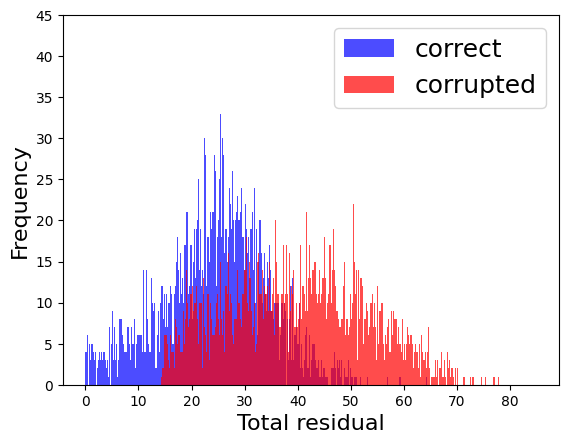

Histogram on testset plotted and saved


In [ ]:
# Test
# Config: Shuffle 16 80x80
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib.pyplot as plt

# import pdb

with torch.no_grad():
    # Prepare arrays for results
    test_loss_lstm = 0.0
    dist_correct_imgs, dist_corrupted_imgs = [], []
    first_correct, first_corrupt = True, True
    count_omitted = 0

    # Process Each Image in the Dataset
    for i, img_name in enumerate(sorted(os.listdir(IMG_DIR))):
        # if i > 2: break
        # print(img_name)
        if not img_name.endswith((".jpg", ".png")):
            continue

        img_path = os.path.join(IMG_DIR, img_name)
        image_source, image = load_image(img_path)
        image = image.to(DEVICE)
        # image_source <class 'numpy.ndarray'> (530, 730, 3) [0, 255]
        # image <class 'torch.Tensor'> torch.Size([3, 800, 1101])

        # Process image_source and image
        target_height, target_width = 480, 640
        image_source = transforms.functional.to_tensor(image_source)
        image_source = transforms.functional.resize(image_source, (target_height, target_width), transforms.InterpolationMode.BILINEAR)
        image = transforms.functional.resize(image, (target_height, target_width), transforms.InterpolationMode.BILINEAR)
        # print(image_source.shape, image.shape)

        # Corrupt the image_source if its corrupt_label is 1
        if corrupt_labels[i] == 1 or LSTM_config.all_corrupt:
            corruption_type = LSTM_config.corruption_type
            if corruption_type == "patch_shuffling":
                image_source, image = corrupt_img_landmark_shuffle(tensors=[image_source, image],
                                                                    num_distortion=LSTM_config.num_distortion,
                                                                    patch_size=LSTM_config.patch_size)
            elif corruption_type == "puzzle_solving":
                image_source, image = corrupt_img_permute(tensors=[image_source, image],
                                                          num_permute=LSTM_config.num_permute,
                                                          patch_size=LSTM_config.patch_size)
            elif corruption_type == "black_box":
                image_source, image = corrupt_img_black_box(tensors=[image_source, image],
                                                            num_box=LSTM_config.num_box,
                                                            patch_size=LSTM_config.patch_size)
            elif corruption_type == "gaussian_blurring":
                image_source, image = corrupt_img_gaussian_blurring(tensors=[image_source, image],
                                                                    num_box=LSTM_config.num_box,
                                                                    patch_size=LSTM_config.patch_size,
                                                                    kernel_size=(31, 31),
                                                                    sigma=10)
            elif corruption_type == 'none':
                pass
            else:
                raise ValueError("Corruption type not recognized, choose among 'patch_shuffling', 'puzzle_solving', 'black_box', and 'gaussian blurring'!")

        if not LSTM_config.corruption_type == "puzzle_solving":
            # Convert image_source back to numpy array
            image_source = image_source.permute(1, 2, 0).numpy()
            image_source = (image_source * 255).astype(np.uint8)  # Convert back to uint8 format

            # Pass image, image_source to grounding DINO, grounded SAM2
            with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float32): # bfloat16 might give error in one forwarding layer
                sam2_predictor.set_image(image_source)
                # Object detection with Grounding DINO
                boxes, confidences, labels = predict(
                    model=grounding_model,
                    image=image,
                    caption=TEXT_PROMPT,
                    box_threshold=BOX_THRESHOLD,
                    text_threshold=TEXT_THRESHOLD,
                )
            if len(boxes) == 0:
                print(f"⚠️ No objects detected in {img_name}")
                count_omitted += 1
                continue

            # Convert to proper format for SAM2
            h, w, _ = image_source.shape
            boxes = boxes * torch.Tensor([w, h, w, h])
            input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

            torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

            if torch.cuda.get_device_properties(0).major >= 8:
                torch.backends.cuda.matmul.allow_tf32 = True
                torch.backends.cudnn.allow_tf32 = True

            # Segment the objects using SAM2
            masks, scores, logits = sam2_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_boxes,
                multimask_output=False,
            )

            # Convert masks shape (n, H, W)
            if masks.ndim == 4:
                masks = masks.squeeze(1)
            class_ids = np.array(list(range(len(labels))))  # Assign class indices

            pred_labels = generate_segmentation_tensor(masks, class_ids, num_classes=13).unsqueeze(0).float().to(DEVICE) # (bs, 480, 640), range [0, 13]
            # print(pred_labels.shape, pred_labels.dtype, pred_labels.device, pred_labels.unique())

            pred_patch_masks = unfold(X=pred_labels.unsqueeze(1), patch_size=LSTM_config.patch_size) # (bs, num_patch, num_ch=1, ps, ps)
            # print(pred_patch_masks.shape, pred_patch_masks.dtype)

            # Transform from cropped masks to their semantics
            num_pixels = pred_patch_masks.shape[3] * pred_patch_masks.shape[4] # ps*ps
            pred_patch_masks = pred_patch_masks.flatten(start_dim=2, end_dim=4) # (bs, num_patch, ps*ps)
            pred_patch_masks = torch.clamp(pred_patch_masks, min=0, max=13)
            # print(pred_patch_masks.min(), pred_patch_masks.max())

            mask_semantics = torch.nn.functional.one_hot(pred_patch_masks.long(), num_classes=14).sum(dim=2) # (bs, num_patch, num_semantics)
            # print(mask_semantics.max(), mask_semantics.min())
            mask_semantics_ratio = (mask_semantics.float()) / num_pixels # (bs, num_patch, num_semantics)

            # LSTM inference
            h0, c0 = model_lstm._init_hidden(1)
            # (2, 16, 14) (D*num_layers, N=bs, H_out), (2, 16, 14) (D*num_layers, N, H_cell), D=2 if bidirectional otherwise 1
            # Compute MSE loss between output_lstm and next semantics embeddings (128-d)
            output_lstm, (hn, cn) = model_lstm([pred_patch_masks, mask_semantics_ratio], (h0, c0))
            output_lstm = torch.clamp(output_lstm, min=-1e3, max=1e3)

            # print("Checking before moving to GPU:")
            # print(torch.isnan(output_lstm.cpu()).any(), torch.isinf(output_lstm.cpu()).any())
            # print(torch.isnan(output_lstm).any(), torch.isinf(output_lstm).any())
            # print(torch.isnan(mask_semantics_ratio).any(), torch.isinf(mask_semantics_ratio).any())
            # print(output_lstm.shape, mask_semantics_ratio.shape)
            # print(output_lstm.device, mask_semantics_ratio.device)

            # Forward loss
            test_loss_lstm += mse_loss(output_lstm[:, :-1, :LSTM_config.semantics_dim], mask_semantics_ratio[:, 1:, :]).item() #  both (bs, num_patch-1, num_semantics)
            # Backward loss
            test_loss_lstm += mse_loss(output_lstm[:, 1:, LSTM_config.semantics_dim:], mask_semantics_ratio[:, :-1, :]).item() # both (bs, num_patch-1, num_semantics)

            dist_batch_imgs_for = torch.norm((output_lstm[:, :-1, :LSTM_config.semantics_dim] - mask_semantics_ratio[:, 1:, :]), dim=2, keepdim=False) # (bs, num_patch-1)
            dist_batch_imgs_back = torch.norm((output_lstm[:, 1:, LSTM_config.semantics_dim:] - mask_semantics_ratio[:, :-1, :]), dim=2, keepdim=False) # (bs, num_patch-1)
            dist_batch_imgs = dist_batch_imgs_for + dist_batch_imgs_back # (bs, num_patch-1)
            # print(dist_batch_imgs.shape)
            # print(dist_batch_imgs)

            # concat to the dist array for all test images
            if first_correct and corrupt_labels[i]==0:
                dist_correct_imgs = dist_batch_imgs
                first_correct = False
            elif first_corrupt and corrupt_labels[i]==1:
                dist_corrupted_imgs = dist_batch_imgs
                first_corrupt = False
            elif corrupt_labels[i]==0:
                dist_correct_imgs = torch.cat((dist_correct_imgs, dist_batch_imgs), dim=0)
            else:
                dist_corrupted_imgs = torch.cat((dist_corrupted_imgs, dist_batch_imgs), dim=0)

        # Print every 50 images
        if (i+1) % 50 == 0:
            if not LSTM_config.corruption_type == "puzzle_solving":
                print(f"Current process: {i+1}/{NUM_TEST}")
            else:
                print(f"Current process: {i+1}/{NUM_TEST}")

# Inference analysis
if not LSTM_config.corruption_type == "puzzle_solving":
    print("Average test Loss (LSTM) over all test images: {:.5f}\n".format(test_loss_lstm / (i+1)))
    log_dict['test_loss_lstm'].append(test_loss_lstm / (i+1))

    # Use torch.hist for picking threshold and computing test accuracy
    dist_correct_imgs, dist_corrupted_imgs = np.array(dist_correct_imgs), np.array(dist_corrupted_imgs) # both (len//2, num_patch-1)
    dist_correct_mean, dist_corrupted_mean = dist_correct_imgs.sum(1), dist_corrupted_imgs.sum(1)

    hist_correct, bin_edges_correct = np.histogram(dist_correct_mean, bins=np.arange(0, 120.05, 0.2))
    hist_corrupted, bin_edges_corrupted = np.histogram(dist_corrupted_mean, bins=np.arange(0, 120.05, 0.2))
    # Stats
    print("Number of test samples taken into account in hist: correct: {}, corrupted: {}".format(hist_correct.sum(), hist_corrupted.sum()))
    print("Correct sample mean distance range: {} to {}".format(dist_correct_mean.min(), dist_correct_mean.max()))
    print("Corrupted sample mean distance range: {} to {}".format(dist_corrupted_mean.min(), dist_corrupted_mean.max()))

    # Determine threshold
    cutoff_index = np.where(hist_corrupted>hist_correct)[0][0]
    first_occ_threshold = bin_edges_correct[cutoff_index] # first occurence
    print("First occurence where there're more corrupted samples than correct samples: %.2f" % (first_occ_threshold))

    # best_f1 = 0
    best_score = 0
    best_threshold = 0
    for cutoff_index in range(0, bin_edges_correct.shape[0]):
        threshold = bin_edges_correct[cutoff_index] # first occurence
        num_fp, num_fn = hist_correct[cutoff_index:].sum(), hist_corrupted[:cutoff_index].sum()
        num_tp, num_tn = hist_corrupted[cutoff_index:].sum(), hist_correct[:cutoff_index].sum()
        test_acc = (num_tn + num_tp) / (num_fn + num_fp + num_tn + num_tp + 1e-6) * 100
        det_acc = (num_tp) / (num_fn + num_tp + 1e-6) * 100
        # precision = num_tp / (num_tp + num_fp + 1e-6)
        # recall = num_tp / (num_tp + num_fn + 1e-6)
        # f1 = 2 * precision * recall / (precision + recall)
        # if f1 > best_f1:
        #     best_f1 = f1
        if (0.5 * num_tn + 0.5 * num_tp) > best_score:
            best_score = 0.5 * num_tn + 0.5 * num_tp
            best_threshold = threshold
        print("Threshold: %.2f" %(threshold), "test accuracy %.3f%%, det accuracy %.3f%%, fn %d, fp %d, tn %d, tp %d" % (test_acc, det_acc, num_fn, num_fp, num_tn, num_tp))
    print("Best threshold: %.2f, best_score: %.3f" % (best_threshold, best_score))

    plt.figure()
    plt.hist(dist_correct_mean, bins=np.arange(0, 85.05, 0.2), alpha=0.7, color='b', label='correct')
    plt.hist(dist_corrupted_mean, bins=np.arange(0, 85.05, 0.2), alpha=0.7, color='r', label='corrupted')
    plt.xticks(np.arange(0, 85, 10))
    plt.yticks(np.arange(0, 47, 5))
    plt.xlabel('Total residual', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend(["correct", "corrupted"], fontsize="18", loc ="upper right")
    plt.savefig(os.path.join(inf_output_dir, 'hist_distavg_on_test.png'))
    plt.show()
    plt.close()
    print("Histogram on testset plotted and saved")

In [ ]:
# Test
# Config: Black 16 80x80
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib.pyplot as plt

# import pdb

with torch.no_grad():
    # Prepare arrays for results
    test_loss_lstm = 0.0
    dist_correct_imgs, dist_corrupted_imgs = [], []
    first_correct, first_corrupt = True, True
    count_omitted = 0

    # Process Each Image in the Dataset
    for i, img_name in enumerate(sorted(os.listdir(IMG_DIR))):
        # if i > 2: break
        # print(img_name)
        if not img_name.endswith((".jpg", ".png")):
            continue

        img_path = os.path.join(IMG_DIR, img_name)
        image_source, image = load_image(img_path)
        image = image.to(DEVICE)
        # image_source <class 'numpy.ndarray'> (530, 730, 3) [0, 255]
        # image <class 'torch.Tensor'> torch.Size([3, 800, 1101])

        # Process image_source and image
        target_height, target_width = 480, 640
        image_source = transforms.functional.to_tensor(image_source)
        image_source = transforms.functional.resize(image_source, (target_height, target_width), transforms.InterpolationMode.BILINEAR)
        image = transforms.functional.resize(image, (target_height, target_width), transforms.InterpolationMode.BILINEAR)
        # print(image_source.shape, image.shape)

        # Corrupt the image_source if its corrupt_label is 1
        if corrupt_labels[i] == 1 or LSTM_config.all_corrupt:
            corruption_type = LSTM_config.corruption_type
            if corruption_type == "patch_shuffling":
                image_source, image = corrupt_img_landmark_shuffle(tensors=[image_source, image],
                                                                    num_distortion=LSTM_config.num_distortion,
                                                                    patch_size=LSTM_config.patch_size)
            elif corruption_type == "puzzle_solving":
                image_source, image = corrupt_img_permute(tensors=[image_source, image],
                                                          num_permute=LSTM_config.num_permute,
                                                          patch_size=LSTM_config.patch_size)
            elif corruption_type == "black_box":
                image_source, image = corrupt_img_black_box(tensors=[image_source, image],
                                                            num_box=LSTM_config.num_box,
                                                            patch_size=LSTM_config.patch_size)
            elif corruption_type == "gaussian_blurring":
                image_source, image = corrupt_img_gaussian_blurring(tensors=[image_source, image],
                                                                    num_box=LSTM_config.num_box,
                                                                    patch_size=LSTM_config.patch_size,
                                                                    kernel_size=(31, 31),
                                                                    sigma=10)
            elif corruption_type == 'none':
                pass
            else:
                raise ValueError("Corruption type not recognized, choose among 'patch_shuffling', 'puzzle_solving', 'black_box', and 'gaussian blurring'!")

        if not LSTM_config.corruption_type == "puzzle_solving":
            # Convert image_source back to numpy array
            image_source = image_source.permute(1, 2, 0).numpy()
            image_source = (image_source * 255).astype(np.uint8)  # Convert back to uint8 format

            # Pass image, image_source to grounding DINO, grounded SAM2
            with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float32): # bfloat16 might give error in one forwarding layer
                sam2_predictor.set_image(image_source)
                # Object detection with Grounding DINO
                boxes, confidences, labels = predict(
                    model=grounding_model,
                    image=image,
                    caption=TEXT_PROMPT,
                    box_threshold=BOX_THRESHOLD,
                    text_threshold=TEXT_THRESHOLD,
                )
            if len(boxes) == 0:
                print(f"⚠️ No objects detected in {img_name}")
                count_omitted += 1
                continue

            # Convert to proper format for SAM2
            h, w, _ = image_source.shape
            boxes = boxes * torch.Tensor([w, h, w, h])
            input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

            torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

            if torch.cuda.get_device_properties(0).major >= 8:
                torch.backends.cuda.matmul.allow_tf32 = True
                torch.backends.cudnn.allow_tf32 = True

            # Segment the objects using SAM2
            masks, scores, logits = sam2_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_boxes,
                multimask_output=False,
            )

            # Convert masks shape (n, H, W)
            if masks.ndim == 4:
                masks = masks.squeeze(1)
            class_ids = np.array(list(range(len(labels))))  # Assign class indices

            pred_labels = generate_segmentation_tensor(masks, class_ids, num_classes=13).unsqueeze(0).float().to(DEVICE) # (bs, 480, 640), range [0, 13]
            # print(pred_labels.shape, pred_labels.dtype, pred_labels.device, pred_labels.unique())

            pred_patch_masks = unfold(X=pred_labels.unsqueeze(1), patch_size=LSTM_config.patch_size) # (bs, num_patch, num_ch=1, ps, ps)
            # print(pred_patch_masks.shape, pred_patch_masks.dtype)

            # Transform from cropped masks to their semantics
            num_pixels = pred_patch_masks.shape[3] * pred_patch_masks.shape[4] # ps*ps
            pred_patch_masks = pred_patch_masks.flatten(start_dim=2, end_dim=4) # (bs, num_patch, ps*ps)
            pred_patch_masks = torch.clamp(pred_patch_masks, min=0, max=13)
            # print(pred_patch_masks.min(), pred_patch_masks.max())

            mask_semantics = torch.nn.functional.one_hot(pred_patch_masks.long(), num_classes=14).sum(dim=2) # (bs, num_patch, num_semantics)
            # print(mask_semantics.max(), mask_semantics.min())
            mask_semantics_ratio = (mask_semantics.float()) / num_pixels # (bs, num_patch, num_semantics)

            # LSTM inference
            h0, c0 = model_lstm._init_hidden(1)
            # (2, 16, 14) (D*num_layers, N=bs, H_out), (2, 16, 14) (D*num_layers, N, H_cell), D=2 if bidirectional otherwise 1
            # Compute MSE loss between output_lstm and next semantics embeddings (128-d)
            output_lstm, (hn, cn) = model_lstm([pred_patch_masks, mask_semantics_ratio], (h0, c0))
            output_lstm = torch.clamp(output_lstm, min=-1e3, max=1e3)

            # print("Checking before moving to GPU:")
            # print(torch.isnan(output_lstm.cpu()).any(), torch.isinf(output_lstm.cpu()).any())
            # print(torch.isnan(output_lstm).any(), torch.isinf(output_lstm).any())
            # print(torch.isnan(mask_semantics_ratio).any(), torch.isinf(mask_semantics_ratio).any())
            # print(output_lstm.shape, mask_semantics_ratio.shape)
            # print(output_lstm.device, mask_semantics_ratio.device)

            # Forward loss
            test_loss_lstm += mse_loss(output_lstm[:, :-1, :LSTM_config.semantics_dim], mask_semantics_ratio[:, 1:, :]).item() #  both (bs, num_patch-1, num_semantics)
            # Backward loss
            test_loss_lstm += mse_loss(output_lstm[:, 1:, LSTM_config.semantics_dim:], mask_semantics_ratio[:, :-1, :]).item() # both (bs, num_patch-1, num_semantics)

            dist_batch_imgs_for = torch.norm((output_lstm[:, :-1, :LSTM_config.semantics_dim] - mask_semantics_ratio[:, 1:, :]), dim=2, keepdim=False) # (bs, num_patch-1)
            dist_batch_imgs_back = torch.norm((output_lstm[:, 1:, LSTM_config.semantics_dim:] - mask_semantics_ratio[:, :-1, :]), dim=2, keepdim=False) # (bs, num_patch-1)
            dist_batch_imgs = dist_batch_imgs_for + dist_batch_imgs_back # (bs, num_patch-1)
            # print(dist_batch_imgs.shape)
            # print(dist_batch_imgs)

            # concat to the dist array for all test images
            if first_correct and corrupt_labels[i]==0:
                dist_correct_imgs = dist_batch_imgs
                first_correct = False
            elif first_corrupt and corrupt_labels[i]==1:
                dist_corrupted_imgs = dist_batch_imgs
                first_corrupt = False
            elif corrupt_labels[i]==0:
                dist_correct_imgs = torch.cat((dist_correct_imgs, dist_batch_imgs), dim=0)
            else:
                dist_corrupted_imgs = torch.cat((dist_corrupted_imgs, dist_batch_imgs), dim=0)

        # Print every 50 images
        if (i+1) % 50 == 0:
            if not LSTM_config.corruption_type == "puzzle_solving":
                print(f"Current process: {i+1}/{NUM_TEST}")
            else:
                print(f"Current process: {i+1}/{NUM_TEST}")


Current process: 50/5050
Current process: 100/5050
⚠️ No objects detected in img-000101.jpg
⚠️ No objects detected in img-000115.jpg
Current process: 150/5050
⚠️ No objects detected in img-000196.jpg
Current process: 200/5050
⚠️ No objects detected in img-000204.jpg
Current process: 250/5050
⚠️ No objects detected in img-000290.jpg
Current process: 300/5050
Current process: 350/5050
Current process: 400/5050
⚠️ No objects detected in img-000414.jpg
⚠️ No objects detected in img-000415.jpg
⚠️ No objects detected in img-000419.jpg
Current process: 450/5050
Current process: 500/5050
⚠️ No objects detected in img-000537.jpg
Current process: 550/5050
Current process: 600/5050
Current process: 650/5050
Current process: 700/5050
Current process: 750/5050
Current process: 800/5050
Current process: 850/5050
Current process: 900/5050
⚠️ No objects detected in img-000936.jpg
Current process: 950/5050
⚠️ No objects detected in img-000960.jpg
⚠️ No objects detected in img-000962.jpg
Current process

Average test Loss (LSTM) over all test images: 0.22780

Number of test samples taken into account in hist: correct: 2389, corrupted: 2477
Correct sample mean distance range: 38.44622039794922 to 143.3583221435547
Corrupted sample mean distance range: 38.12040710449219 to 165.02938842773438
First occurence where there're more corrupted samples than correct samples: 38.00
Threshold: 0.00 test accuracy 50.904%, det accuracy 100.000%, fn 0, fp 2389, tn 0, tp 2477
Threshold: 0.20 test accuracy 50.904%, det accuracy 100.000%, fn 0, fp 2389, tn 0, tp 2477
Threshold: 0.40 test accuracy 50.904%, det accuracy 100.000%, fn 0, fp 2389, tn 0, tp 2477
Threshold: 0.60 test accuracy 50.904%, det accuracy 100.000%, fn 0, fp 2389, tn 0, tp 2477
Threshold: 0.80 test accuracy 50.904%, det accuracy 100.000%, fn 0, fp 2389, tn 0, tp 2477
Threshold: 1.00 test accuracy 50.904%, det accuracy 100.000%, fn 0, fp 2389, tn 0, tp 2477
Threshold: 1.20 test accuracy 50.904%, det accuracy 100.000%, fn 0, fp 2389, tn 0

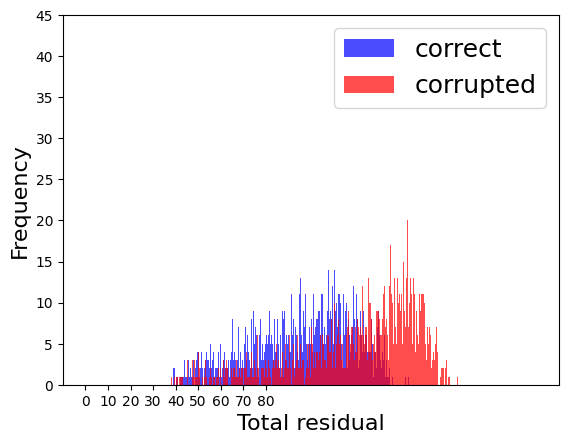

Histogram on testset plotted and saved


In [23]:
# Inference analysis
if not LSTM_config.corruption_type == "puzzle_solving":
    print("Average test Loss (LSTM) over all test images: {:.5f}\n".format(test_loss_lstm / (i+1)))
    log_dict['test_loss_lstm'].append(test_loss_lstm / (i+1))

    # Use torch.hist for picking threshold and computing test accuracy
    dist_correct_imgs, dist_corrupted_imgs = np.array(dist_correct_imgs), np.array(dist_corrupted_imgs) # both (len//2, num_patch-1)
    dist_correct_mean, dist_corrupted_mean = dist_correct_imgs.sum(1), dist_corrupted_imgs.sum(1)

    hist_correct, bin_edges_correct = np.histogram(dist_correct_mean, bins=np.arange(0, 200.05, 0.2))
    hist_corrupted, bin_edges_corrupted = np.histogram(dist_corrupted_mean, bins=np.arange(0, 200.05, 0.2))
    # Stats
    print("Number of test samples taken into account in hist: correct: {}, corrupted: {}".format(hist_correct.sum(), hist_corrupted.sum()))
    print("Correct sample mean distance range: {} to {}".format(dist_correct_mean.min(), dist_correct_mean.max()))
    print("Corrupted sample mean distance range: {} to {}".format(dist_corrupted_mean.min(), dist_corrupted_mean.max()))

    # Determine threshold
    cutoff_index = np.where(hist_corrupted>hist_correct)[0][0]
    first_occ_threshold = bin_edges_correct[cutoff_index] # first occurence
    print("First occurence where there're more corrupted samples than correct samples: %.2f" % (first_occ_threshold))

    # best_f1 = 0
    best_score = 0
    best_threshold = 0
    for cutoff_index in range(0, bin_edges_correct.shape[0]):
        threshold = bin_edges_correct[cutoff_index] # first occurence
        num_fp, num_fn = hist_correct[cutoff_index:].sum(), hist_corrupted[:cutoff_index].sum()
        num_tp, num_tn = hist_corrupted[cutoff_index:].sum(), hist_correct[:cutoff_index].sum()
        test_acc = (num_tn + num_tp) / (num_fn + num_fp + num_tn + num_tp + 1e-6) * 100
        det_acc = (num_tp) / (num_fn + num_tp + 1e-6) * 100
        # precision = num_tp / (num_tp + num_fp + 1e-6)
        # recall = num_tp / (num_tp + num_fn + 1e-6)
        # f1 = 2 * precision * recall / (precision + recall)
        # if f1 > best_f1:
        #     best_f1 = f1
        if (0.5 * num_tn + 0.5 * num_tp) > best_score:
            best_score = 0.5 * num_tn + 0.5 * num_tp
            best_threshold = threshold
        print("Threshold: %.2f" %(threshold), "test accuracy %.3f%%, det accuracy %.3f%%, fn %d, fp %d, tn %d, tp %d" % (test_acc, det_acc, num_fn, num_fp, num_tn, num_tp))
    print("Best threshold: %.2f, best_score: %.3f" % (best_threshold, best_score))

    plt.figure()
    plt.hist(dist_correct_mean, bins=np.arange(0, 200.05, 0.2), alpha=0.7, color='b', label='correct')
    plt.hist(dist_corrupted_mean, bins=np.arange(0, 200.05, 0.2), alpha=0.7, color='r', label='corrupted')
    plt.xticks(np.arange(0, 85, 10))
    plt.yticks(np.arange(0, 47, 5))
    plt.xlabel('Total residual', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend(["correct", "corrupted"], fontsize="18", loc ="upper right")
    plt.savefig(os.path.join(inf_output_dir, 'hist_black_16_80x80_th=.png'))
    plt.show()
    plt.close()
    print("Histogram on testset plotted and saved")

In [ ]:
# Test
# Config: Shuffle 4 160x160
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib.pyplot as plt

# import pdb

with torch.no_grad():
    # Prepare arrays for results
    test_loss_lstm = 0.0
    dist_correct_imgs, dist_corrupted_imgs = [], []
    first_correct, first_corrupt = True, True
    count_omitted = 0

    # Process Each Image in the Dataset
    for i, img_name in enumerate(sorted(os.listdir(IMG_DIR))):
        # if i > 2: break
        # print(img_name)
        if not img_name.endswith((".jpg", ".png")):
            continue

        img_path = os.path.join(IMG_DIR, img_name)
        image_source, image = load_image(img_path)
        image = image.to(DEVICE)
        # image_source <class 'numpy.ndarray'> (530, 730, 3) [0, 255]
        # image <class 'torch.Tensor'> torch.Size([3, 800, 1101])

        # Process image_source and image
        target_height, target_width = 480, 640
        image_source = transforms.functional.to_tensor(image_source)
        image_source = transforms.functional.resize(image_source, (target_height, target_width), transforms.InterpolationMode.BILINEAR)
        image = transforms.functional.resize(image, (target_height, target_width), transforms.InterpolationMode.BILINEAR)
        # print(image_source.shape, image.shape)

        # Corrupt the image_source if its corrupt_label is 1
        # print(LSTM_config.patch_size, LSTM_config.num_distortion)
        if corrupt_labels[i] == 1 or LSTM_config.all_corrupt:
            corruption_type = LSTM_config.corruption_type
            if corruption_type == "patch_shuffling":
                image_source, image = corrupt_img_landmark_shuffle(tensors=[image_source, image],
                                                                    num_distortion=LSTM_config.num_distortion,
                                                                    patch_size=LSTM_config.patch_size)
            elif corruption_type == "puzzle_solving":
                image_source, image = corrupt_img_permute(tensors=[image_source, image],
                                                          num_permute=LSTM_config.num_permute,
                                                          patch_size=LSTM_config.patch_size)
            elif corruption_type == "black_box":
                image_source, image = corrupt_img_black_box(tensors=[image_source, image],
                                                            num_box=LSTM_config.num_box,
                                                            patch_size=LSTM_config.patch_size)
            elif corruption_type == "gaussian_blurring":
                image_source, image = corrupt_img_gaussian_blurring(tensors=[image_source, image],
                                                                    num_box=LSTM_config.num_box,
                                                                    patch_size=LSTM_config.patch_size,
                                                                    kernel_size=(31, 31),
                                                                    sigma=10)
            elif corruption_type == 'none':
                pass
            else:
                raise ValueError("Corruption type not recognized, choose among 'patch_shuffling', 'puzzle_solving', 'black_box', and 'gaussian blurring'!")

        if not LSTM_config.corruption_type == "puzzle_solving":
            # Convert image_source back to numpy array
            image_source = image_source.permute(1, 2, 0).numpy()
            image_source = (image_source * 255).astype(np.uint8)  # Convert back to uint8 format

            # Pass image, image_source to grounding DINO, grounded SAM2
            with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float32): # bfloat16 might give error in one forwarding layer
                sam2_predictor.set_image(image_source)
                # Object detection with Grounding DINO
                boxes, confidences, labels = predict(
                    model=grounding_model,
                    image=image,
                    caption=TEXT_PROMPT,
                    box_threshold=BOX_THRESHOLD,
                    text_threshold=TEXT_THRESHOLD,
                )
            if len(boxes) == 0:
                print(f"⚠️ No objects detected in {img_name}")
                count_omitted += 1
                continue

            # Convert to proper format for SAM2
            h, w, _ = image_source.shape
            boxes = boxes * torch.Tensor([w, h, w, h])
            input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

            torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

            if torch.cuda.get_device_properties(0).major >= 8:
                torch.backends.cuda.matmul.allow_tf32 = True
                torch.backends.cudnn.allow_tf32 = True

            # Segment the objects using SAM2
            masks, scores, logits = sam2_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_boxes,
                multimask_output=False,
            )

            # Convert masks shape (n, H, W)
            if masks.ndim == 4:
                masks = masks.squeeze(1)
            class_ids = np.array(list(range(len(labels))))  # Assign class indices

            pred_labels = generate_segmentation_tensor(masks, class_ids, num_classes=13).unsqueeze(0).float().to(DEVICE) # (bs, 480, 640), range [0, 13]
            # print(pred_labels.shape, pred_labels.dtype, pred_labels.device, pred_labels.unique())

            pred_patch_masks = unfold(X=pred_labels.unsqueeze(1), patch_size=LSTM_config.patch_size) # (bs, num_patch, num_ch=1, ps, ps)
            # print(pred_patch_masks.shape, pred_patch_masks.dtype)

            # Transform from cropped masks to their semantics
            num_pixels = pred_patch_masks.shape[3] * pred_patch_masks.shape[4] # ps*ps
            pred_patch_masks = pred_patch_masks.flatten(start_dim=2, end_dim=4) # (bs, num_patch, ps*ps)
            pred_patch_masks = torch.clamp(pred_patch_masks, min=0, max=13)
            # print(pred_patch_masks.min(), pred_patch_masks.max())

            mask_semantics = torch.nn.functional.one_hot(pred_patch_masks.long(), num_classes=14).sum(dim=2) # (bs, num_patch, num_semantics)
            # print(mask_semantics.max(), mask_semantics.min())
            mask_semantics_ratio = (mask_semantics.float()) / num_pixels # (bs, num_patch, num_semantics)

            # LSTM inference
            h0, c0 = model_lstm._init_hidden(1)
            # (2, 16, 14) (D*num_layers, N=bs, H_out), (2, 16, 14) (D*num_layers, N, H_cell), D=2 if bidirectional otherwise 1
            # Compute MSE loss between output_lstm and next semantics embeddings (128-d)
            output_lstm, (hn, cn) = model_lstm([pred_patch_masks, mask_semantics_ratio], (h0, c0))
            output_lstm = torch.clamp(output_lstm, min=-1e3, max=1e3)

            # print("Checking before moving to GPU:")
            # print(torch.isnan(output_lstm.cpu()).any(), torch.isinf(output_lstm.cpu()).any())
            # print(torch.isnan(output_lstm).any(), torch.isinf(output_lstm).any())
            # print(torch.isnan(mask_semantics_ratio).any(), torch.isinf(mask_semantics_ratio).any())
            # print(output_lstm.shape, mask_semantics_ratio.shape)
            # print(output_lstm.device, mask_semantics_ratio.device)

            # Forward loss
            test_loss_lstm += mse_loss(output_lstm[:, :-1, :LSTM_config.semantics_dim], mask_semantics_ratio[:, 1:, :]).item() #  both (bs, num_patch-1, num_semantics)
            # Backward loss
            test_loss_lstm += mse_loss(output_lstm[:, 1:, LSTM_config.semantics_dim:], mask_semantics_ratio[:, :-1, :]).item() # both (bs, num_patch-1, num_semantics)

            dist_batch_imgs_for = torch.norm((output_lstm[:, :-1, :LSTM_config.semantics_dim] - mask_semantics_ratio[:, 1:, :]), dim=2, keepdim=False) # (bs, num_patch-1)
            dist_batch_imgs_back = torch.norm((output_lstm[:, 1:, LSTM_config.semantics_dim:] - mask_semantics_ratio[:, :-1, :]), dim=2, keepdim=False) # (bs, num_patch-1)
            dist_batch_imgs = dist_batch_imgs_for + dist_batch_imgs_back # (bs, num_patch-1)
            # print(dist_batch_imgs.shape)
            # print(dist_batch_imgs)

            # concat to the dist array for all test images
            if first_correct and corrupt_labels[i]==0:
                dist_correct_imgs = dist_batch_imgs
                first_correct = False
            elif first_corrupt and corrupt_labels[i]==1:
                dist_corrupted_imgs = dist_batch_imgs
                first_corrupt = False
            elif corrupt_labels[i]==0:
                dist_correct_imgs = torch.cat((dist_correct_imgs, dist_batch_imgs), dim=0)
            else:
                dist_corrupted_imgs = torch.cat((dist_corrupted_imgs, dist_batch_imgs), dim=0)

        # Print every 50 images
        if (i+1) % 50 == 0:
            if not LSTM_config.corruption_type == "puzzle_solving":
                print(f"Current process: {i+1}/{NUM_TEST}")
            else:
                print(f"Current process: {i+1}/{NUM_TEST}")


Current process: 50/5050
Current process: 100/5050
⚠️ No objects detected in img-000115.jpg
Current process: 150/5050
Current process: 200/5050
Current process: 250/5050
⚠️ No objects detected in img-000290.jpg
Current process: 300/5050
Current process: 350/5050
⚠️ No objects detected in img-000392.jpg
⚠️ No objects detected in img-000394.jpg
Current process: 400/5050
⚠️ No objects detected in img-000415.jpg
⚠️ No objects detected in img-000419.jpg
Current process: 450/5050
Current process: 500/5050
⚠️ No objects detected in img-000501.jpg
⚠️ No objects detected in img-000537.jpg
Current process: 550/5050
Current process: 600/5050
Current process: 650/5050
Current process: 700/5050
Current process: 750/5050
Current process: 800/5050
⚠️ No objects detected in img-000824.jpg
Current process: 850/5050
Current process: 900/5050
⚠️ No objects detected in img-000936.jpg
⚠️ No objects detected in img-000945.jpg
⚠️ No objects detected in img-000949.jpg
Current process: 950/5050
⚠️ No objects d

160
Average test Loss (LSTM) over all test images: 0.24818

Number of test samples taken into account in hist: correct: 2450, corrupted: 2374
Correct sample mean distance range: -1.1585731506347656 to 30.47018051147461
Corrupted sample mean distance range: 18.970260620117188 to 49.13439178466797
First occurence where there're more corrupted samples than correct samples: 26.40
Threshold: 0.00 test accuracy 49.212%, det accuracy 100.000%, fn 0, fp 2450, tn 0, tp 2374
Threshold: 0.20 test accuracy 49.254%, det accuracy 100.000%, fn 0, fp 2448, tn 2, tp 2374
Threshold: 0.40 test accuracy 49.274%, det accuracy 100.000%, fn 0, fp 2447, tn 3, tp 2374
Threshold: 0.60 test accuracy 49.274%, det accuracy 100.000%, fn 0, fp 2447, tn 3, tp 2374
Threshold: 0.80 test accuracy 49.274%, det accuracy 100.000%, fn 0, fp 2447, tn 3, tp 2374
Threshold: 1.00 test accuracy 49.274%, det accuracy 100.000%, fn 0, fp 2447, tn 3, tp 2374
Threshold: 1.20 test accuracy 49.295%, det accuracy 100.000%, fn 0, fp 2446

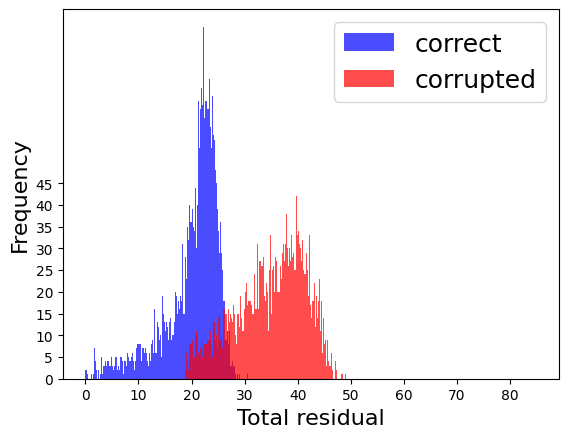

Histogram on testset plotted and saved


In [ ]:
# Inference analysis
print(LSTM_config.patch_size)
if not LSTM_config.corruption_type == "puzzle_solving":
    print("Average test Loss (LSTM) over all test images: {:.5f}\n".format(test_loss_lstm / (i+1)))
    log_dict['test_loss_lstm'].append(test_loss_lstm / (i+1))

    # Use torch.hist for picking threshold and computing test accuracy
    dist_correct_imgs, dist_corrupted_imgs = np.array(dist_correct_imgs), np.array(dist_corrupted_imgs) # both (len//2, num_patch-1)
    dist_correct_mean, dist_corrupted_mean = dist_correct_imgs.sum(1), dist_corrupted_imgs.sum(1)

    hist_correct, bin_edges_correct = np.histogram(dist_correct_mean, bins=np.arange(0, 120.05, 0.2))
    hist_corrupted, bin_edges_corrupted = np.histogram(dist_corrupted_mean, bins=np.arange(0, 120.05, 0.2))
    # Stats
    print("Number of test samples taken into account in hist: correct: {}, corrupted: {}".format(hist_correct.sum(), hist_corrupted.sum()))
    print("Correct sample mean distance range: {} to {}".format(dist_correct_mean.min(), dist_correct_mean.max()))
    print("Corrupted sample mean distance range: {} to {}".format(dist_corrupted_mean.min(), dist_corrupted_mean.max()))

    # Determine threshold
    cutoff_index = np.where(hist_corrupted>hist_correct)[0][0]
    first_occ_threshold = bin_edges_correct[cutoff_index] # first occurence
    print("First occurence where there're more corrupted samples than correct samples: %.2f" % (first_occ_threshold))

    # best_f1 = 0
    best_score = 0
    best_threshold = 0
    for cutoff_index in range(0, bin_edges_correct.shape[0]):
        threshold = bin_edges_correct[cutoff_index] # first occurence
        num_fp, num_fn = hist_correct[cutoff_index:].sum(), hist_corrupted[:cutoff_index].sum()
        num_tp, num_tn = hist_corrupted[cutoff_index:].sum(), hist_correct[:cutoff_index].sum()
        test_acc = (num_tn + num_tp) / (num_fn + num_fp + num_tn + num_tp + 1e-6) * 100
        det_acc = (num_tp) / (num_fn + num_tp + 1e-6) * 100
        # precision = num_tp / (num_tp + num_fp + 1e-6)
        # recall = num_tp / (num_tp + num_fn + 1e-6)
        # f1 = 2 * precision * recall / (precision + recall)
        # if f1 > best_f1:
        #     best_f1 = f1
        if (0.5 * num_tn + 0.5 * num_tp) > best_score:
            best_score = 0.5 * num_tn + 0.5 * num_tp
            best_threshold = threshold
        print("Threshold: %.2f" %(threshold), "test accuracy %.3f%%, det accuracy %.3f%%, fn %d, fp %d, tn %d, tp %d" % (test_acc, det_acc, num_fn, num_fp, num_tn, num_tp))
    print("Best threshold: %.2f, best_score: %.3f" % (best_threshold, best_score))

    plt.figure()
    plt.hist(dist_correct_mean, bins=np.arange(0, 85.05, 0.2), alpha=0.7, color='b', label='correct')
    plt.hist(dist_corrupted_mean, bins=np.arange(0, 85.05, 0.2), alpha=0.7, color='r', label='corrupted')
    plt.xticks(np.arange(0, 85, 10))
    plt.yticks(np.arange(0, 47, 5))
    plt.xlabel('Total residual', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend(["correct", "corrupted"], fontsize="18", loc ="upper right")
    plt.savefig(os.path.join(inf_output_dir, 'hist_distavg_on_test.png'))
    plt.show()
    plt.close()
    print("Histogram on testset plotted and saved")

In [ ]:
# Test
# Config: Black 4 160x160
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib.pyplot as plt

# import pdb

with torch.no_grad():
    # Prepare arrays for results
    test_loss_lstm = 0.0
    dist_correct_imgs, dist_corrupted_imgs = [], []
    first_correct, first_corrupt = True, True
    count_omitted = 0

    # Process Each Image in the Dataset
    for i, img_name in enumerate(sorted(os.listdir(IMG_DIR))):
        # if i > 2: break
        # print(img_name)
        if not img_name.endswith((".jpg", ".png")):
            continue

        img_path = os.path.join(IMG_DIR, img_name)
        image_source, image = load_image(img_path)
        image = image.to(DEVICE)
        # image_source <class 'numpy.ndarray'> (530, 730, 3) [0, 255]
        # image <class 'torch.Tensor'> torch.Size([3, 800, 1101])

        # Process image_source and image
        target_height, target_width = 480, 640
        image_source = transforms.functional.to_tensor(image_source)
        image_source = transforms.functional.resize(image_source, (target_height, target_width), transforms.InterpolationMode.BILINEAR)
        image = transforms.functional.resize(image, (target_height, target_width), transforms.InterpolationMode.BILINEAR)
        # print(image_source.shape, image.shape)

        # Corrupt the image_source if its corrupt_label is 1
        if corrupt_labels[i] == 1 or LSTM_config.all_corrupt:
            corruption_type = LSTM_config.corruption_type
            if corruption_type == "patch_shuffling":
                image_source, image = corrupt_img_landmark_shuffle(tensors=[image_source, image],
                                                                    num_distortion=LSTM_config.num_distortion,
                                                                    patch_size=LSTM_config.patch_size)
            elif corruption_type == "puzzle_solving":
                image_source, image = corrupt_img_permute(tensors=[image_source, image],
                                                          num_permute=LSTM_config.num_permute,
                                                          patch_size=LSTM_config.patch_size)
            elif corruption_type == "black_box":
                image_source, image = corrupt_img_black_box(tensors=[image_source, image],
                                                            num_box=LSTM_config.num_box,
                                                            patch_size=LSTM_config.patch_size)
            elif corruption_type == "gaussian_blurring":
                image_source, image = corrupt_img_gaussian_blurring(tensors=[image_source, image],
                                                                    num_box=LSTM_config.num_box,
                                                                    patch_size=LSTM_config.patch_size,
                                                                    kernel_size=(31, 31),
                                                                    sigma=10)
            elif corruption_type == 'none':
                pass
            else:
                raise ValueError("Corruption type not recognized, choose among 'patch_shuffling', 'puzzle_solving', 'black_box', and 'gaussian blurring'!")

        if not LSTM_config.corruption_type == "puzzle_solving":
            # Convert image_source back to numpy array
            image_source = image_source.permute(1, 2, 0).numpy()
            image_source = (image_source * 255).astype(np.uint8)  # Convert back to uint8 format

            # Pass image, image_source to grounding DINO, grounded SAM2
            with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float32): # bfloat16 might give error in one forwarding layer
                sam2_predictor.set_image(image_source)
                # Object detection with Grounding DINO
                boxes, confidences, labels = predict(
                    model=grounding_model,
                    image=image,
                    caption=TEXT_PROMPT,
                    box_threshold=BOX_THRESHOLD,
                    text_threshold=TEXT_THRESHOLD,
                )
            if len(boxes) == 0:
                print(f"⚠️ No objects detected in {img_name}")
                count_omitted += 1
                continue

            # Convert to proper format for SAM2
            h, w, _ = image_source.shape
            boxes = boxes * torch.Tensor([w, h, w, h])
            input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

            torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

            if torch.cuda.get_device_properties(0).major >= 8:
                torch.backends.cuda.matmul.allow_tf32 = True
                torch.backends.cudnn.allow_tf32 = True

            # Segment the objects using SAM2
            masks, scores, logits = sam2_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_boxes,
                multimask_output=False,
            )

            # Convert masks shape (n, H, W)
            if masks.ndim == 4:
                masks = masks.squeeze(1)
            class_ids = np.array(list(range(len(labels))))  # Assign class indices

            pred_labels = generate_segmentation_tensor(masks, class_ids, num_classes=13).unsqueeze(0).float().to(DEVICE) # (bs, 480, 640), range [0, 13]
            # print(pred_labels.shape, pred_labels.dtype, pred_labels.device, pred_labels.unique())

            pred_patch_masks = unfold(X=pred_labels.unsqueeze(1), patch_size=LSTM_config.patch_size) # (bs, num_patch, num_ch=1, ps, ps)
            # print(pred_patch_masks.shape, pred_patch_masks.dtype)

            # Transform from cropped masks to their semantics
            num_pixels = pred_patch_masks.shape[3] * pred_patch_masks.shape[4] # ps*ps
            pred_patch_masks = pred_patch_masks.flatten(start_dim=2, end_dim=4) # (bs, num_patch, ps*ps)
            pred_patch_masks = torch.clamp(pred_patch_masks, min=0, max=13)
            # print(pred_patch_masks.min(), pred_patch_masks.max())

            mask_semantics = torch.nn.functional.one_hot(pred_patch_masks.long(), num_classes=14).sum(dim=2) # (bs, num_patch, num_semantics)
            # print(mask_semantics.max(), mask_semantics.min())
            mask_semantics_ratio = (mask_semantics.float()) / num_pixels # (bs, num_patch, num_semantics)

            # LSTM inference
            h0, c0 = model_lstm._init_hidden(1)
            # (2, 16, 14) (D*num_layers, N=bs, H_out), (2, 16, 14) (D*num_layers, N, H_cell), D=2 if bidirectional otherwise 1
            # Compute MSE loss between output_lstm and next semantics embeddings (128-d)
            output_lstm, (hn, cn) = model_lstm([pred_patch_masks, mask_semantics_ratio], (h0, c0))
            output_lstm = torch.clamp(output_lstm, min=-1e3, max=1e3)

            # print("Checking before moving to GPU:")
            # print(torch.isnan(output_lstm.cpu()).any(), torch.isinf(output_lstm.cpu()).any())
            # print(torch.isnan(output_lstm).any(), torch.isinf(output_lstm).any())
            # print(torch.isnan(mask_semantics_ratio).any(), torch.isinf(mask_semantics_ratio).any())
            # print(output_lstm.shape, mask_semantics_ratio.shape)
            # print(output_lstm.device, mask_semantics_ratio.device)

            # Forward loss
            test_loss_lstm += mse_loss(output_lstm[:, :-1, :LSTM_config.semantics_dim], mask_semantics_ratio[:, 1:, :]).item() #  both (bs, num_patch-1, num_semantics)
            # Backward loss
            test_loss_lstm += mse_loss(output_lstm[:, 1:, LSTM_config.semantics_dim:], mask_semantics_ratio[:, :-1, :]).item() # both (bs, num_patch-1, num_semantics)

            dist_batch_imgs_for = torch.norm((output_lstm[:, :-1, :LSTM_config.semantics_dim] - mask_semantics_ratio[:, 1:, :]), dim=2, keepdim=False) # (bs, num_patch-1)
            dist_batch_imgs_back = torch.norm((output_lstm[:, 1:, LSTM_config.semantics_dim:] - mask_semantics_ratio[:, :-1, :]), dim=2, keepdim=False) # (bs, num_patch-1)
            dist_batch_imgs = dist_batch_imgs_for + dist_batch_imgs_back # (bs, num_patch-1)
            # print(dist_batch_imgs.shape)
            # print(dist_batch_imgs)

            # concat to the dist array for all test images
            if first_correct and corrupt_labels[i]==0:
                dist_correct_imgs = dist_batch_imgs
                first_correct = False
            elif first_corrupt and corrupt_labels[i]==1:
                dist_corrupted_imgs = dist_batch_imgs
                first_corrupt = False
            elif corrupt_labels[i]==0:
                dist_correct_imgs = torch.cat((dist_correct_imgs, dist_batch_imgs), dim=0)
            else:
                dist_corrupted_imgs = torch.cat((dist_corrupted_imgs, dist_batch_imgs), dim=0)

        # Print every 50 images
        if (i+1) % 50 == 0:
            if not LSTM_config.corruption_type == "puzzle_solving":
                print(f"Current process: {i+1}/{NUM_TEST}")
            else:
                print(f"Current process: {i+1}/{NUM_TEST}")



Current process: 50/5050
Current process: 100/5050
⚠️ No objects detected in img-000115.jpg
Current process: 150/5050
⚠️ No objects detected in img-000199.jpg
⚠️ No objects detected in img-000200.jpg
Current process: 250/5050
⚠️ No objects detected in img-000290.jpg
⚠️ No objects detected in img-000291.jpg
Current process: 300/5050
Current process: 350/5050
Current process: 400/5050
⚠️ No objects detected in img-000415.jpg
⚠️ No objects detected in img-000419.jpg
Current process: 450/5050
Current process: 500/5050
⚠️ No objects detected in img-000516.jpg
Current process: 550/5050
Current process: 600/5050
Current process: 650/5050
Current process: 700/5050
Current process: 750/5050
Current process: 800/5050
Current process: 850/5050
Current process: 900/5050
⚠️ No objects detected in img-000939.jpg
⚠️ No objects detected in img-000946.jpg
Current process: 950/5050
⚠️ No objects detected in img-000966.jpg
⚠️ No objects detected in img-000977.jpg
Current process: 1000/5050
⚠️ No objects 

Average test Loss (LSTM) over all test images: 0.23592

Number of test samples taken into account in hist: correct: 2466, corrupted: 2368
Correct sample mean distance range: -1.1585731506347656 to 29.178783416748047
Corrupted sample mean distance range: 19.017770767211914 to 47.06368637084961
First occurence where there're more corrupted samples than correct samples: 26.60
Threshold: 0.00 test accuracy 48.986%, det accuracy 100.000%, fn 0, fp 2466, tn 0, tp 2368
Threshold: 0.20 test accuracy 49.007%, det accuracy 100.000%, fn 0, fp 2465, tn 1, tp 2368
Threshold: 0.40 test accuracy 49.069%, det accuracy 100.000%, fn 0, fp 2462, tn 4, tp 2368
Threshold: 0.60 test accuracy 49.069%, det accuracy 100.000%, fn 0, fp 2462, tn 4, tp 2368
Threshold: 0.80 test accuracy 49.090%, det accuracy 100.000%, fn 0, fp 2461, tn 5, tp 2368
Threshold: 1.00 test accuracy 49.110%, det accuracy 100.000%, fn 0, fp 2460, tn 6, tp 2368
Threshold: 1.20 test accuracy 49.131%, det accuracy 100.000%, fn 0, fp 2459, t

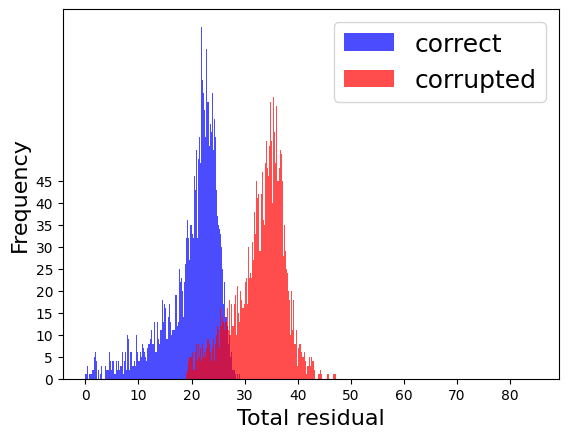

Histogram on testset plotted and saved


In [ ]:
# Inference analysis
if not LSTM_config.corruption_type == "puzzle_solving":
    print("Average test Loss (LSTM) over all test images: {:.5f}\n".format(test_loss_lstm / (i+1)))
    log_dict['test_loss_lstm'].append(test_loss_lstm / (i+1))

    # Use torch.hist for picking threshold and computing test accuracy
    dist_correct_imgs, dist_corrupted_imgs = np.array(dist_correct_imgs.cpu()), np.array(dist_corrupted_imgs.cpu()) # both (len//2, num_patch-1)
    dist_correct_mean, dist_corrupted_mean = dist_correct_imgs.sum(1), dist_corrupted_imgs.sum(1)

    hist_correct, bin_edges_correct = np.histogram(dist_correct_mean, bins=np.arange(0, 120.05, 0.2))
    hist_corrupted, bin_edges_corrupted = np.histogram(dist_corrupted_mean, bins=np.arange(0, 120.05, 0.2))
    # Stats
    print("Number of test samples taken into account in hist: correct: {}, corrupted: {}".format(hist_correct.sum(), hist_corrupted.sum()))
    print("Correct sample mean distance range: {} to {}".format(dist_correct_mean.min(), dist_correct_mean.max()))
    print("Corrupted sample mean distance range: {} to {}".format(dist_corrupted_mean.min(), dist_corrupted_mean.max()))

    # Determine threshold
    cutoff_index = np.where(hist_corrupted>hist_correct)[0][0]
    first_occ_threshold = bin_edges_correct[cutoff_index] # first occurence
    print("First occurence where there're more corrupted samples than correct samples: %.2f" % (first_occ_threshold))

    # best_f1 = 0
    best_score = 0
    best_threshold = 0
    for cutoff_index in range(0, bin_edges_correct.shape[0]):
        threshold = bin_edges_correct[cutoff_index] # first occurence
        num_fp, num_fn = hist_correct[cutoff_index:].sum(), hist_corrupted[:cutoff_index].sum()
        num_tp, num_tn = hist_corrupted[cutoff_index:].sum(), hist_correct[:cutoff_index].sum()
        test_acc = (num_tn + num_tp) / (num_fn + num_fp + num_tn + num_tp + 1e-6) * 100
        det_acc = (num_tp) / (num_fn + num_tp + 1e-6) * 100
        # precision = num_tp / (num_tp + num_fp + 1e-6)
        # recall = num_tp / (num_tp + num_fn + 1e-6)
        # f1 = 2 * precision * recall / (precision + recall)
        # if f1 > best_f1:
        #     best_f1 = f1
        if (0.5 * num_tn + 0.5 * num_tp) > best_score:
            best_score = 0.5 * num_tn + 0.5 * num_tp
            best_threshold = threshold
        print("Threshold: %.2f" %(threshold), "test accuracy %.3f%%, det accuracy %.3f%%, fn %d, fp %d, tn %d, tp %d" % (test_acc, det_acc, num_fn, num_fp, num_tn, num_tp))
    print("Best threshold: %.2f, best_score: %.3f" % (best_threshold, best_score))

    plt.figure()
    plt.hist(dist_correct_mean, bins=np.arange(0, 85.05, 0.2), alpha=0.7, color='b', label='correct')
    plt.hist(dist_corrupted_mean, bins=np.arange(0, 85.05, 0.2), alpha=0.7, color='r', label='corrupted')
    plt.xticks(np.arange(0, 85, 10))
    plt.yticks(np.arange(0, 47, 5))
    plt.xlabel('Total residual', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend(["correct", "corrupted"], fontsize="18", loc ="upper right")
    plt.savefig(os.path.join(inf_output_dir, 'hist_distavg_on_test.png'))
    plt.show()
    plt.close()
    print("Histogram on testset plotted and saved")

In [ ]:
from google.colab import runtime

runtime.unassign()